# Tiny Imagenet

In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES']='2'

In [2]:
import shutil,timm,os,torch,random,datasets,math
import fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
# import k_diffusion as K, 
import torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from torchvision.io import read_image,ImageReadMode
from glob import glob

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.training import *

# from miniai.xtras import *

/home/galopy/miniforge3/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at /opt/conda/conda-bld/pytorch_1702400410390/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
from fastprogress import progress_bar

In [4]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Data processing

In [5]:
path = Path.home()/'data'/'tiny-imagenet-200'

In [6]:
bs = 512

In [7]:
class TinyDS:
    def __init__(self, path):
        self.path = Path(path)
        self.files = glob(str(path/'**/*.JPEG'), recursive=True)
    def __len__(self): return len(self.files)
    def __getitem__(self, i): return self.files[i],Path(self.files[i]).parent.parent.name

In [8]:
tds = TinyDS(path/'train')

In [9]:
tds[0]

('/home/galopy/data/tiny-imagenet-200/train/n07579787/images/n07579787_140.JPEG',
 'n07579787')

In [10]:
path_anno = path/'val'/'val_annotations.txt'
anno = dict(o.split('\t')[:2] for o in path_anno.read_text().splitlines())

In [11]:
path_anno.read_text().splitlines()[0].split('\t')

['val_0.JPEG', 'n03444034', '0', '32', '44', '62']

In [12]:
anno['val_0.JPEG']

'n03444034'

In [13]:
class TinyValDS(TinyDS):
    def __getitem__(self, i): return self.files[i],anno[os.path.basename(self.files[i])]

In [14]:
vds = TinyValDS(path/'val')

In [15]:
vds[0]

('/home/galopy/data/tiny-imagenet-200/val/images/val_8594.JPEG', 'n02132136')

In [16]:
len(tds)

100000

In [17]:
class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop): self.ds,self.tfmx,self.tfmy = ds,tfmx,tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        x,y = self.ds[i]
        return self.tfmx(x),self.tfmy(y)

In [18]:
id2str = (path/'wnids.txt').read_text().splitlines()
str2id = {v:k for k,v in enumerate(id2str)}

In [19]:
xmean,xstd = (tensor([0.47565, 0.40303, 0.31555]), tensor([0.28858, 0.24402, 0.26615]))

In [53]:
def tfmx(x):
    img = read_image(x, mode=ImageReadMode.RGB)/255
    return (img-xmean[:,None,None])/xstd[:,None,None]

In [54]:
def tfmy(y): return tensor(str2id[y])

In [25]:
tfm_tds = TfmDS(tds, tfmx, tfmy)
tfm_vds = TfmDS(vds, tfmx, tfmy)

In [26]:
xi,yi = tfm_tds[0]
id2str[yi]

'n07579787'

In [60]:
yi

tensor(143)

In [27]:
def denorm(x): return (x*xstd[:,None,None]+xmean[:,None,None]).clip(0,1)

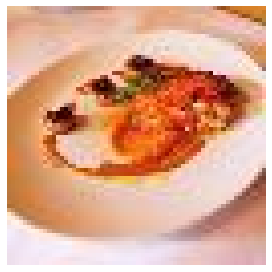

In [58]:
show_image(denorm(xi));

In [59]:
dltrn = DataLoader(tfm_tds, batch_size=bs, shuffle=True, num_workers=8)

In [33]:
xb,yb = b = next(iter(dltrn))

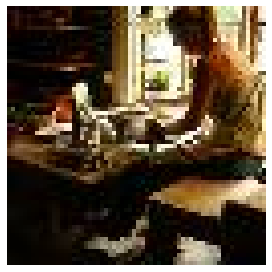

In [34]:
show_image(denorm(xb[0]));

In [62]:
all_synsets = [o.split('\t') for o in (path/'words.txt').read_text().splitlines()]
synsets = {k:v.split(',', maxsplit=1)[0] for k,v in all_synsets if k in id2str}

In [66]:
id2str

['n02124075',
 'n04067472',
 'n04540053',
 'n04099969',
 'n07749582',
 'n01641577',
 'n02802426',
 'n09246464',
 'n07920052',
 'n03970156',
 'n03891332',
 'n02106662',
 'n03201208',
 'n02279972',
 'n02132136',
 'n04146614',
 'n07873807',
 'n02364673',
 'n04507155',
 'n03854065',
 'n03838899',
 'n03733131',
 'n01443537',
 'n07875152',
 'n03544143',
 'n09428293',
 'n03085013',
 'n02437312',
 'n07614500',
 'n03804744',
 'n04265275',
 'n02963159',
 'n02486410',
 'n01944390',
 'n09256479',
 'n02058221',
 'n04275548',
 'n02321529',
 'n02769748',
 'n02099712',
 'n07695742',
 'n02056570',
 'n02281406',
 'n01774750',
 'n02509815',
 'n03983396',
 'n07753592',
 'n04254777',
 'n02233338',
 'n04008634',
 'n02823428',
 'n02236044',
 'n03393912',
 'n07583066',
 'n04074963',
 'n01629819',
 'n09332890',
 'n02481823',
 'n03902125',
 'n03404251',
 'n09193705',
 'n03637318',
 'n04456115',
 'n02666196',
 'n03796401',
 'n02795169',
 'n02123045',
 'n01855672',
 'n01882714',
 'n02917067',
 'n02988304',
 'n043

In [65]:
all_synsets

[['n00001740', 'entity'],
 ['n00001930', 'physical entity'],
 ['n00002137', 'abstraction, abstract entity'],
 ['n00002452', 'thing'],
 ['n00002684', 'object, physical object'],
 ['n00003553', 'whole, unit'],
 ['n00003993', 'congener'],
 ['n00004258', 'living thing, animate thing'],
 ['n00004475', 'organism, being'],
 ['n00005787', 'benthos'],
 ['n00005930', 'dwarf'],
 ['n00006024', 'heterotroph'],
 ['n00006150', 'parent'],
 ['n00006269', 'life'],
 ['n00006400', 'biont'],
 ['n00006484', 'cell'],
 ['n00007347', 'causal agent, cause, causal agency'],
 ['n00007846', 'person, individual, someone, somebody, mortal, soul'],
 ['n00015388', 'animal, animate being, beast, brute, creature, fauna'],
 ['n00017222', 'plant, flora, plant life'],
 ['n00019046', 'native'],
 ['n00019128', 'natural object'],
 ['n00019613', 'substance'],
 ['n00020090', 'substance'],
 ['n00020827', 'matter'],
 ['n00021265', 'food, nutrient'],
 ['n00021734', 'nutrient'],
 ['n00021939', 'artifact, artefact'],
 ['n00022903', 

In [67]:
synsets

{'n01443537': 'goldfish',
 'n01629819': 'European fire salamander',
 'n01641577': 'bullfrog',
 'n01644900': 'tailed frog',
 'n01698640': 'American alligator',
 'n01742172': 'boa constrictor',
 'n01768244': 'trilobite',
 'n01770393': 'scorpion',
 'n01774384': 'black widow',
 'n01774750': 'tarantula',
 'n01784675': 'centipede',
 'n01855672': 'goose',
 'n01882714': 'koala',
 'n01910747': 'jellyfish',
 'n01917289': 'brain coral',
 'n01944390': 'snail',
 'n01945685': 'slug',
 'n01950731': 'sea slug',
 'n01983481': 'American lobster',
 'n01984695': 'spiny lobster',
 'n02002724': 'black stork',
 'n02056570': 'king penguin',
 'n02058221': 'albatross',
 'n02074367': 'dugong',
 'n02085620': 'Chihuahua',
 'n02094433': 'Yorkshire terrier',
 'n02099601': 'golden retriever',
 'n02099712': 'Labrador retriever',
 'n02106662': 'German shepherd',
 'n02113799': 'standard poodle',
 'n02123045': 'tabby',
 'n02123394': 'Persian cat',
 'n02124075': 'Egyptian cat',
 'n02125311': 'cougar',
 'n02129165': 'lion'

In [63]:
titles = [synsets[id2str[o]] for o in yb]
', '.join(titles[:20])

"potter's wheel, ice cream, scorpion, basketball, ox, cliff, CD player, sandal, baboon, pomegranate, rugby ball, sandal, mantis, suspension bridge, sewing machine, sea cucumber, ice cream, confectionery, reel, lesser panda"

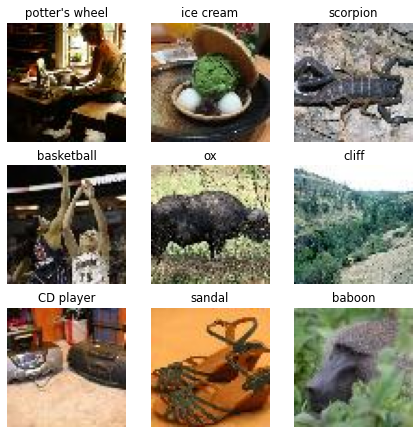

In [64]:
show_images(denorm(xb[:9]), titles=titles[:9], imsize=2.5)

In [68]:
dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=8))

## Basic model

In [69]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

In [71]:
tfms = nn.Sequential(T.Pad(4), T.RandomCrop(64),
                     T.RandomHorizontalFlip(),
                     RandErase())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [74]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [75]:
nfs = (32,64,128,256,512,1024)

In [ ]:
def get_dropmodel(act=act_gr, nfs=nfs, norm=nn.BatchNorm2d, drop=0.1):
    layers = [nn.Conv2d(3, nfs[0], 5, padding=2)]
#     layers += [ResBlock(nfs[0], nfs[0], ks=3, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    layers += [nn.Linear(nfs[-1], 200, bias=False), nn.BatchNorm1d(200)]
    return nn.Sequential(*layers).apply(iw)

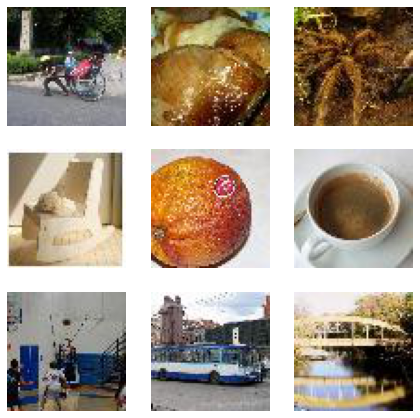

In [ ]:
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, cbs=[SingleBatchCB(), augcb, DeviceCB()])
learn.fit(1)
xb,yb = learn.batch
show_images(denorm(xb.cpu())[:9], imsize=2.5)

In [ ]:
learn.summary()

Tot params: 19775824; MFLOPS: 303.7


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Conv2d|(512, 3, 64, 64)|(512, 32, 64, 64)|2432|9.8|
|ResBlock|(512, 32, 64, 64)|(512, 64, 32, 32)|57792|58.7|
|ResBlock|(512, 64, 32, 32)|(512, 128, 16, 16)|230272|58.7|
|ResBlock|(512, 128, 16, 16)|(512, 256, 8, 8)|919296|58.7|
|ResBlock|(512, 256, 8, 8)|(512, 512, 4, 4)|3673600|58.7|
|ResBlock|(512, 512, 4, 4)|(512, 1024, 2, 2)|14687232|58.7|
|AdaptiveAvgPool2d|(512, 1024, 2, 2)|(512, 1024, 1, 1)|0|0.0|
|Flatten|(512, 1024, 1, 1)|(512, 1024)|0|0.0|
|Dropout|(512, 1024)|(512, 1024)|0|0.0|
|Linear|(512, 1024)|(512, 200)|204800|0.2|
|BatchNorm1d|(512, 200)|(512, 200)|400|0.0|


In [ ]:
opt_func = partial(optim.AdamW, eps=1e-5)

In [ ]:
lr_cbs = [DeviceCB(), augcb, MixedPrecision(), ProgressCB()]

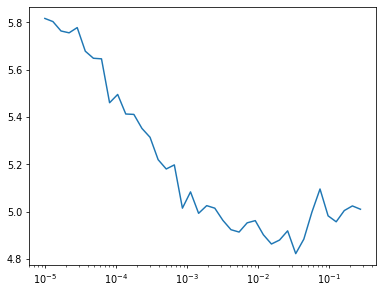

In [ ]:
learn = Learner(get_dropmodel(), dls, F.cross_entropy, cbs=lr_cbs, opt_func=opt_func)
learn.lr_find()

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision()]

In [ ]:
epochs = 25
lr = 0.1
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
learn = Learner(get_dropmodel(), dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

accuracy,loss,epoch,train
0.112,4.370,0,train
0.169,3.852,0,eval
0.224,3.580,1,train
0.245,3.385,1,eval
0.272,3.244,2,train
0.241,3.557,2,eval
0.306,3.025,3,train
0.228,3.717,3,eval
0.336,2.856,4,train
0.280,3.414,4,eval


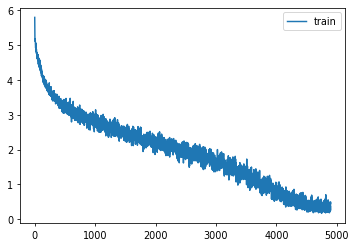

In [ ]:
learn.fit(epochs)

In [ ]:
torch.save(learn.model, 'models/inettiny-basic-25')

## Deeper

In [ ]:
def res_blocks(n_bk, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
    return nn.Sequential(*[
        ResBlock(ni if i==0 else nf, nf, stride=stride if i==n_bk-1 else 1, ks=ks, act=act, norm=norm)
        for i in range(n_bk)])

In [ ]:
nbks = (3,2,2,1,1)

In [ ]:
def get_dropmodel(act=act_gr, nfs=nfs, nbks=nbks, norm=nn.BatchNorm2d, drop=0.2):
    layers = [ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm)]
    layers += [res_blocks(nbks[i], nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    layers += [nn.Linear(nfs[-1], 200, bias=False), nn.BatchNorm1d(200)]
    return nn.Sequential(*layers).apply(iw)

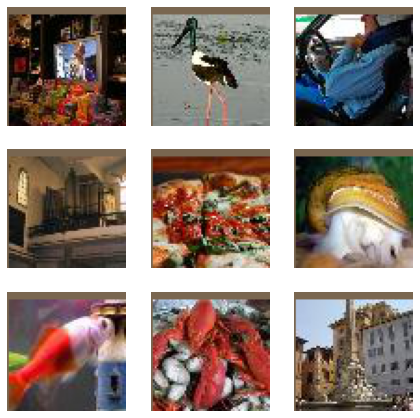

In [ ]:
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, cbs=[SingleBatchCB(), augcb, DeviceCB()])
learn.fit(1)
xb,yb = learn.batch
show_images(denorm(xb.cpu())[:9], imsize=2.5)

In [ ]:
learn.summary()

Tot params: 21426800; MFLOPS: 710.9


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(512, 3, 64, 64)|(512, 32, 64, 64)|28320|115.1|
|Sequential|(512, 32, 64, 64)|(512, 64, 32, 32)|206016|209.7|
|Sequential|(512, 64, 32, 32)|(512, 128, 16, 16)|525952|134.2|
|Sequential|(512, 128, 16, 16)|(512, 256, 8, 8)|2100480|134.2|
|Sequential|(512, 256, 8, 8)|(512, 512, 4, 4)|3673600|58.7|
|Sequential|(512, 512, 4, 4)|(512, 1024, 2, 2)|14687232|58.7|
|AdaptiveAvgPool2d|(512, 1024, 2, 2)|(512, 1024, 1, 1)|0|0.0|
|Flatten|(512, 1024, 1, 1)|(512, 1024)|0|0.0|
|Dropout|(512, 1024)|(512, 1024)|0|0.0|
|Linear|(512, 1024)|(512, 200)|204800|0.2|
|BatchNorm1d|(512, 200)|(512, 200)|400|0.0|


In [ ]:
opt_func = partial(optim.AdamW, eps=1e-5)

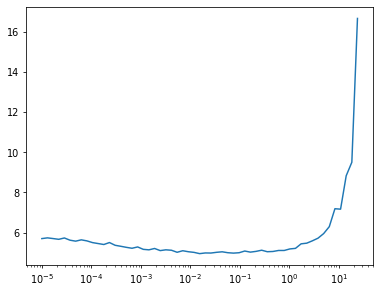

In [ ]:
learn = Learner(get_dropmodel(), dls, F.cross_entropy, cbs=lr_cbs, opt_func=opt_func)
learn.lr_find()

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision()]

epochs = 25
lr = 3e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
learn = Learner(get_dropmodel(), dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

accuracy,loss,epoch,train
0.073,4.595,0,train
0.099,4.283,0,eval
0.175,3.825,1,train
0.192,3.682,1,eval
0.238,3.393,2,train
0.203,3.798,2,eval
0.291,3.075,3,train
0.248,3.404,3,eval
0.329,2.873,4,train
0.275,3.290,4,eval


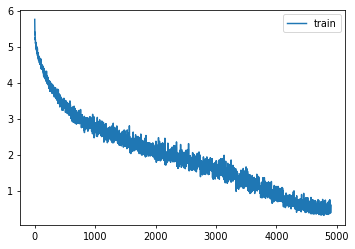

In [ ]:
learn.fit(epochs)

In [ ]:
torch.save(learn.model, 'models/inettiny-custom-25')

## More augmentation

In [ ]:
aug_tfms = nn.Sequential(T.Pad(4), T.RandomCrop(64),
                     T.RandomHorizontalFlip(),
                     T.TrivialAugmentWide())

norm_tfm = T.Normalize(xmean, xstd)
erase_tfm = RandErase()

In [ ]:
from PIL import Image

In [ ]:
def tfmx(x, aug=False):
    x = Image.open(x).convert('RGB')
    if aug: x = aug_tfms(x)
    x = TF.to_tensor(x)
    x = norm_tfm(x)
    if aug: x = erase_tfm(x[None])[0]
    return x

In [ ]:
tfm_tds = TfmDS(tds, partial(tfmx, aug=True), tfmy)
tfm_vds = TfmDS(vds, tfmx, tfmy)

In [ ]:
dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=8))

In [ ]:
def conv(ni, nf, ks=3, stride=1, act=nn.ReLU, norm=None, bias=True):
    layers = []
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias))
    return nn.Sequential(*layers)

def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    return nn.Sequential(conv(ni, nf, stride=1     , act=act, norm=norm, ks=ks),
                         conv(nf, nf, stride=stride, act=act, norm=norm, ks=ks))

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks, norm=norm)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None, norm=norm)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return self.convs(x) + self.idconv(self.pool(x))

def get_dropmodel(act=act_gr, nfs=nfs, nbks=nbks, norm=nn.BatchNorm2d, drop=0.2):
    layers = [nn.Conv2d(3, nfs[0], 5, padding=2)]
    layers += [res_blocks(nbks[i], nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [act_gr(), norm(nfs[-1]), nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    layers += [nn.Linear(nfs[-1], 200, bias=False), nn.BatchNorm1d(200)]
    return nn.Sequential(*layers).apply(iw)

In [ ]:
def get_model(): return get_dropmodel(nbks=(4,3,3,2,1), drop=0.1)

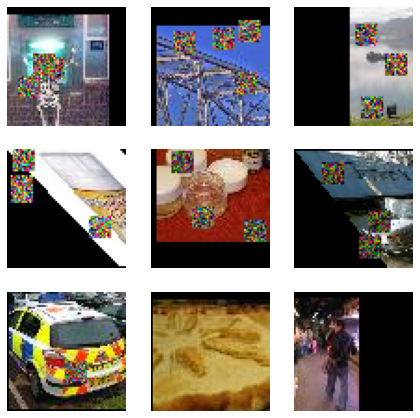

In [ ]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, cbs=[SingleBatchCB(), DeviceCB()])
learn.fit(1)
xb,yb = learn.batch
show_images(denorm(xb.cpu())[:9], imsize=2.5)

In [ ]:
epochs = 50
lr = 0.1
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(get_model(), dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

accuracy,loss,epoch,train
0.026,5.044,0,train
0.035,4.920,0,eval
0.052,4.712,1,train
0.075,4.434,1,eval
0.086,4.417,2,train
0.108,4.135,2,eval
0.121,4.149,3,train
0.141,4.008,3,eval
0.153,3.908,4,train
0.180,3.725,4,eval


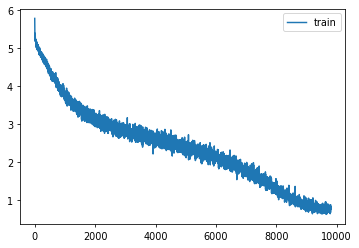

In [ ]:
learn.fit(epochs)

In [ ]:
torch.save(learn.model, 'models/inettiny-trivaug-50')

### fin -